<a href="https://colab.research.google.com/github/RajaSekhar12-Reddy/Deep-Learning-Projects/blob/main/Celebrity_Face_Recognition_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Face Detection:
**Face Detection is the process of automatically locating faces in a photograph and localizing them by drawing a bounding box around their extent.**

##Face Recognition:
**Face recognition is the general task of identifying and verifying people from photographs of their face.**

##Face Verification:
**A one-to-one mapping of a given face against a known identity (e.g. is this the person?).**

##Face Identification:
**A one-to-many mapping for a given face against a database of known faces (e.g. who is this person?).**

##Face Net Pretrained Model
**1)FaceNet is a face recognition system that was described by Florian Schroff,it is a system that, given a picture of a face, will extract high-quality features from the face and predict a 128 element vector representation these features, called a face embedding.These face embeddings were then used as the basis for training classifier systems on standard face recognition benchmark datasets, achieving then-state-of-the-art results.**

**2)We will use the pre-trained Keras FaceNet model provided by Hiroki Taniai.. It was trained on MS-Celeb-1M dataset and expects input images to be color, to have their pixel values whitened (standardized across all three channels), and to have a square shape of 160×160 pixels.**

## The Face Net  model can be downloaded from here:

https://drive.google.com/open?id=1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn

## Loading the FaceNet Model

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
# example of loading the keras facenet model
from tensorflow.python.keras.models import load_model
# load the model
model = load_model("/facenet_keras.h5")
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


##Detecting the Faces

**we will also use the Multi-Task Cascaded Convolutional Neural Network, or MTCNN, for face detection, e.g. finding and extracting faces from photos.**

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 5.6MB/s 


In [ ]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


**The first step is to load an image as a NumPy array, which we can achieve using the PIL library and the open() function. We will also convert the image to RGB, just in case the image has an alpha channel or is black and white.**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


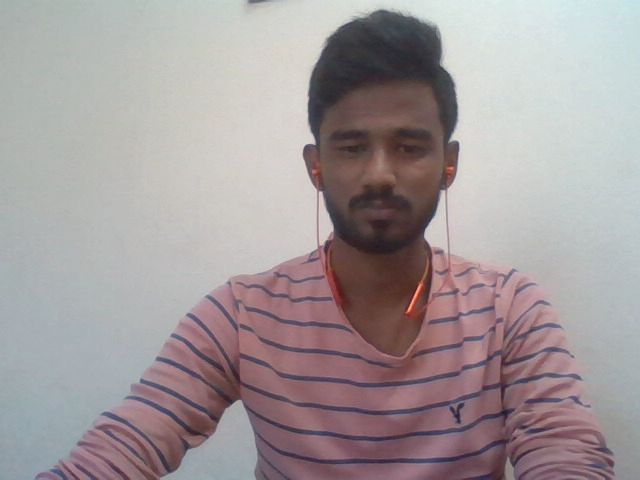

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
from PIL import Image
from numpy import *
# load image from file
image = Image.open("photo.jpg")
# convert to RGB, if needed
image = image.convert('RGB')
# convert to array
pixels = asarray(image)

**Next, we can create an MTCNN face detector class and use it to detect all faces in the loaded photograph.**

In [ ]:
# create the detector, using default weights
detector = mtcnn.MTCNN()
# detect faces in the image
results = detector.detect_faces(pixels)

**The result is a list of bounding boxes, where each bounding box defines a lower-left-corner of the bounding box, as well as the width and height.**

**If we assume there is only one face in the photo for our experiments, we can determine the pixel coordinates of the bounding box as follows. Sometimes the library will return a negative pixel index, and I think this is a bug. We can fix this by taking the absolute value of the coordinates.**

In [ ]:
# extract the bounding box from the first face
x1, y1, width, height = results[0]['box']
# bug fix
x1, y1 = abs(x1), abs(y1)
x2, y2 = x1 + width, y1 + height

**We can use these coordinates to extract the face.**

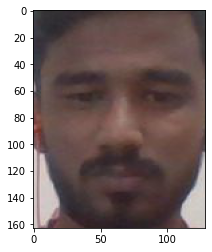

In [ ]:
import matplotlib.pyplot as plt
# extract the face
face = pixels[y1:y2, x1:x2]
plt.imshow(face)   

**We can then use the PIL library to resize this small image of the face to the required size; specifically, the model expects square input faces with the shape 160×160.**

In [ ]:
# resize pixels to the model size
image = Image.fromarray(face)
image = image.resize((160, 160))
face_array = asarray(image)

**Tying all of this together, the function extract_face() will load a photograph from the loaded filename and return the extracted face. It assumes that the photo contains one face and will return the first face detected.**

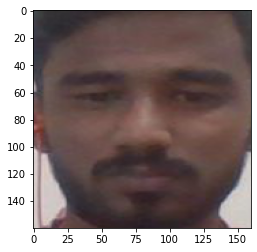

In [ ]:
# function for face detection with mtcnn
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 
# load the photo and extract the face
pixels = extract_face('photo.jpg')
plt.imshow(pixels)

## Developing a Face Classification System

**The model will be trained and tested using the Data "5 Celebrity Faces dataset" that contains many photographs of five different celebrities.
We will use an MTCNN model for face detection, the FaceNet model will be used to create a face embedding for each detected face, then we will develop a Linear Support Vector Machine (SVM) classifier model to predict the identity of a given face.**

## 5 Celebrity Data Set

**The 5 Celebrity Faces Dataset is a small dataset that contains photographs of celebrities.**
**It includes photos of: Ben Affleck, Elton John, Jerry Seinfeld, Madonna, and Mindy Kaling.**

## The DataSet Can be Downloaded Here
https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset

## Detecting Faces

**The first step is to detect the face in each photograph and reduce the dataset to a series of faces only.**

**Let’s test out our face detector function defined in the previous section, specifically extract_face().**

**Looking in the ‘5-celebrity-faces-dataset/train/ben_afflek/‘ directory, we can see that there are 14 photographs of Ben Affleck in the training dataset. We can detect the face in each photograph, and create a plot with 14 faces, with two rows of seven images each.**

In [ ]:
# unzip the file
import zipfile
local_zip="/5 Celebrity Faces Dataset.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("/Face Classification")
zip_ref.close()

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


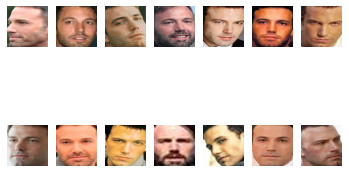

In [ ]:
# demonstrate face detection on 5 Celebrity Faces Dataset
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 
# specify folder to plot
folder="/Face Classification/5 Celebrity Faces Dataset/train/ben_afflek/"
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()

**Next, we can extend this example to step over each subdirectory for a given dataset (e.g. ‘train‘ or ‘val‘), extract the faces, and prepare a dataset with the name as the output label for each detected face.**

**The load_faces() function below will load all of the faces into a list for a given directory, e.g. ‘5-celebrity-faces-dataset/train/ben_afflek/‘.**

In [ ]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

**We can call the load_faces() function for each subdirectory in the ‘train‘ or ‘val‘ folders. Each face has one label, the name of the celebrity, which we can take from the directory name.**

**The load_dataset() function below takes a directory name such as ‘5-celebrity-faces-dataset/train/‘ and detects faces for each subdirectory (celebrity), assigning labels to each detected face.**

**It returns the X and y elements of the dataset as NumPy arrays.**

In [ ]:
# load a dataset that contains one subdir for each class that in turn contains images
import os
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not os.path.isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

**We can then call this function for the ‘train’ and ‘val’ folders to load all of the data, then save the results in a single compressed NumPy array file via the savez_compressed() function.**

In [ ]:
# load train dataset
trainX, trainy = load_dataset('/Face Classification/5 Celebrity Faces Dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/Face Classification/5 Celebrity Faces Dataset/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 19 examples for class: madonna
>loaded 17 examples for class: elton_john
>loaded 21 examples for class: jerry_seinfeld
>loaded 22 examples for class: mindy_kaling
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: madonna
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: mindy_kaling
(25, 160, 160, 3) (25,)


## Create Face Embeddings

**A face embedding is a vector that represents the features extracted from the face. This can then be compared with the vectors generated for other faces. For example, another vector that is close (by some measure) may be the same person, whereas another vector that is far (by some measure) may be a different person.**

**The classifier model that we want to develop will take a face embedding as input and predict the identity of the face. The FaceNet model will generate this embedding for a given image of a face.**

**The FaceNet model can be used as part of the classifier itself, or we can use the FaceNet model to pre-process a face to create a face embedding that can be stored and used as input to our classifier model. This latter approach is preferred as the FaceNet model is both large and slow to create a face embedding.**

**We can, therefore, pre-compute the face embeddings for all faces in the train and test (formally ‘val‘) sets in our 5 Celebrity Faces Dataset.**

**First, we can load our detected faces dataset using the load() NumPy function.**

In [ ]:
# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


**We will use the FaceNet Model to convert the faces into face embeddings**

**To predict an embedding, first the pixel values of the image need to be suitably prepared to meet the expectations of the FaceNet model. This specific implementation of the FaceNet model expects that the pixel values are standardized.**

In [ ]:
# scale pixel values
face_pixels = pixels.astype('float32')
# standardize pixel values across channels (global)
mean, std = face_pixels.mean(), face_pixels.std()
face_pixels = (face_pixels - mean) / std

**In order to make a prediction for one example in Keras, we must expand the dimensions so that the face array is one sample.**

In [ ]:
# transform face into one sample
samples = expand_dims(face_pixels, axis=0)

**We can then use the model to make a prediction and extract the embedding vector.**

In [ ]:
# make prediction to get embedding
yhat = model.predict(samples)
# get embedding
embedding = yhat[0]

**The get_embedding() function defined below implements these behaviors and will return a face embedding given a single image of a face and the loaded FaceNet model.**

In [ ]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

**Tying all of this together, the complete example of converting each face into a face embedding in the train and test datasets is listed below.**

In [ ]:

# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
 
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
(93, 128)
(25, 128)


**We can see that the face dataset was loaded correctly and so was the model. The train dataset was then transformed into 93 face embeddings, each comprised of a 128 element vector. The 25 examples in the test dataset were also suitably converted to face embedding.**

##Performing Face Classification

**In this section, we will develop a model to classify face embeddings as one of the known celebrities in the 5 Celebrity Faces Dataset.**

**First, we must load the face embeddings dataset.**

In [ ]:
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=93, test=25


**First, it is a good practice to normalize the face embedding vectors. It is a good practice because the vectors are often compared to each other using a distance metric.**

**In this context, vector normalization means scaling the values until the length or magnitude of the vectors is 1 or unit length. This can be achieved using the Normalizer class in scikit-learn. It might even be more convenient to perform this step when the face embeddings are created in the previous step.**

## Importing the necessary Libraries for Face Classification

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

In [ ]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

**Next, the string target variables for each celebrity name need to be converted to integers.**

**This can be achieved via the LabelEncoder class in scikit-learn.**

In [ ]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

**It is common to use a Linear Support Vector Machine (SVM) when working with normalized face embedding inputs. This is because the method is very effective at separating the face embedding vectors. We can fit a linear SVM to the training data using the SVC class in scikit-learn and setting the ‘kernel‘ attribute to ‘linear‘. We may also want probabilities later when making predictions, which can be configured by setting ‘probability‘ to ‘True‘.**

In [ ]:
# fit model
model = SVC(kernel='linear')
model.fit(trainX, trainy)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**Next, we can evaluate the model.**

**This can be achieved by using the fit model to make a prediction for each example in the train and test datasets and then calculating the classification accuracy.**

In [ ]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


**Tying all of this together, the complete example of fitting a Linear SVM on the face embeddings for the 5 Celebrity Faces Dataset is listed below.**

In [ ]:
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


**We can make it more interesting by plotting the original face and the prediction.**

**First, we need to load the face dataset, specifically the faces in the test dataset. We could also load the original photos to make it even more interesting.**

In [ ]:
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']

**The rest of the example is the same up until we fit the model.**

**First, we need to select a random example from the test set, then get the embedding, face pixels, expected class prediction, and the corresponding name for the class.**

In [ ]:
# test model on a random example from the test dataset
from random import choice
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

**Next, we can use the face embedding as an input to make a single prediction with the fit model.**

**We can predict both the class integer and the probability of the prediction.**

In [ ]:
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

**We can then get the name for the predicted class integer, and the probability for this prediction.**

In [ ]:
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)

**We can then print this information.**

In [ ]:
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

Predicted: mindy_kaling (92.061)
Expected: mindy_kaling


**We can also plot the face pixels along with the predicted name and probability.**

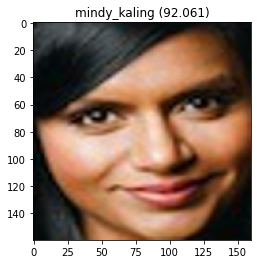

In [ ]:
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

**Tying all of this together, the complete example for predicting the identity for a given unseen photo in the test dataset is listed below.**

Predicted: elton_john (90.230)
Expected: elton_john


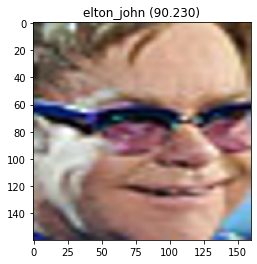

In [ ]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()